In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_1 = pd.read_csv("train_1.csv")

In [3]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [4]:
train_1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


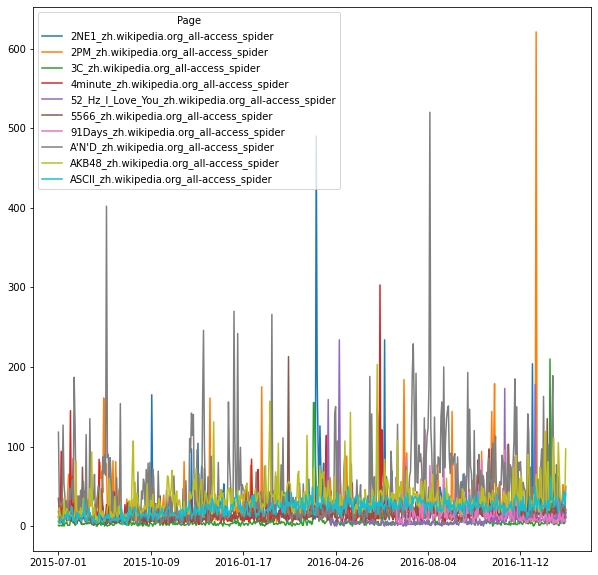

In [5]:
f, ax = plt.subplots(figsize=(10,10))

train_1.set_index("Page").head(10).T.plot(ax=ax)

In [6]:
agent = train_1.Page.apply(lambda x: x.split("_")[-1]).rename("agent")
access = train_1.Page.apply(lambda x: x.split("_")[-2]).rename("access")
wikiproject = train_1.Page.apply(lambda x: x.split("_")[-3]).rename("wikiproject")
page_name = train_1.Page.apply(lambda x: "_".join(x.split("_")[:-3])).rename("page_name")

df1 = pd.concat([page_name, wikiproject, access, agent, train_1], axis=1)

In [7]:
df1.head()

,page_name,wikiproject,access,agent,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh.wikipedia.org,all-access,spider,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM,zh.wikipedia.org,all-access,spider,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C,zh.wikipedia.org,all-access,spider,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute,zh.wikipedia.org,all-access,spider,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [8]:
df1["access"].value_counts()

all-access    74315
mobile-web    35939
desktop       34809
Name: access, dtype: int64

### SMAPE

In [27]:
def smape(A, F):
    return 100/A.size * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F) + np.finfo(float).eps))


In [58]:
Dnum = df1.head(10000).fillna(0).values[:,5:]

In [59]:
smape(np.zeros_like(Dnum), Dnum)

183.63665454545455

In [64]:
Mmean = np.tile(np.mean(Dnum, 1).reshape(-1,1) , (1,Dnum.shape[1]))
smape(Mmean, Dnum)

69.06106596223245